In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as tch
from torch.distributions.beta import Beta
from torch.distributions.gamma import Gamma
from sklearn import neighbors
import pandas as pd
from sklearn.model_selection import train_test_split

# Question 1

In [8]:
def f1(x):
    return pow(x, 3) - (25*pow(x, 2)) + (75*x) + 100
def f1_prime(x):
    return (3*pow(x, 2)) - (50*x) + 75
def f2(x):
    return np.cos(x)
def f2_prime(x):
    return -1*np.sin(x)

In [3]:
def iterate(x, error, f, f_prime, max_iter = 1e5):
    count = 0
    while (f(x) < (-1*error) or f(x) > error) and count < max_iter:
        x = x - (f(x)/f_prime(x))
        count += 1
    return x

In [4]:
def newtons_method(low, high, error, f, f_prime, max_iter = 1e5):
    """ Inputs:
            x: the number at which to start iteration
            error: the error tolerance
            max_iter: the maximum number of iterations the function will run
        Returns
            x: the solution to the equation--f(x) == 0
            f(x): check that the algorithm converges to a solution
            count: the number of iterations needed to reach the solution
        ** f(x) and f_prime(x) must be defined elsewhere **

        This function performs newton's method starting at x until f(x)
        is within the given error of 0 or the maximum number of iterations
        are reached."""

    roots = []
    roots.append(iterate(low, error, f, f_prime, max_iter))
    roots.append(iterate(high, error, f, f_prime, max_iter))
    
    return np.array(roots)

In [6]:
#find the roots for f1
f1_roots = newtons_method(-10, 10, 1e-5, f1, f1_prime)

In [31]:
#I had to adjust the bounds to get the proper results
f2_roots = newtons_method(1, 5, 1e-5, f2, f2_prime)

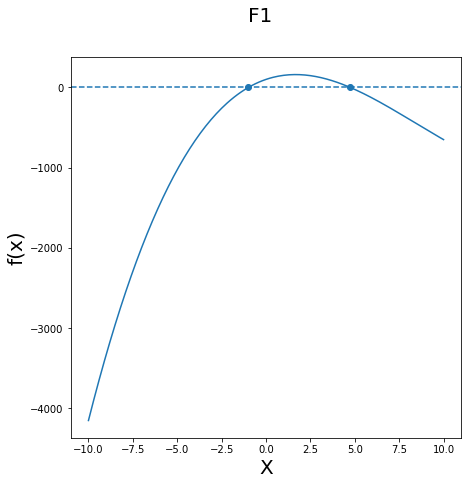

In [20]:
fig1 = plt.figure(num = 1, figsize = [7, 7])
fig1.suptitle("F1", fontsize = 20)
x_axis = np.arange(-10, 10.1, 0.1)
plt.plot(x_axis, f1(x_axis), label = "f1(x)")
plt.xlabel('X', fontsize = 20)
plt.ylabel('f(x)', fontsize = 20)
plt.scatter(f1_roots, [0, 0])
plt.axhline(y = 0, linestyle = 'dashed')
plt.show()

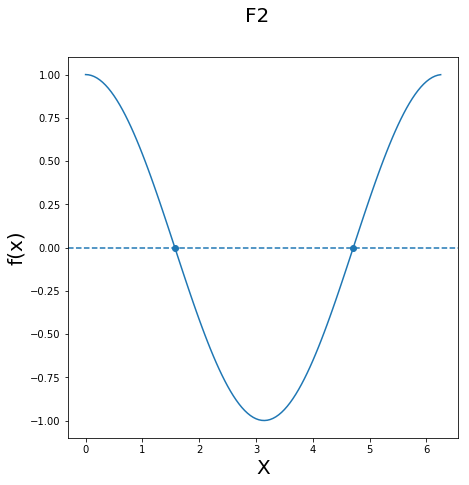

In [33]:
fig2 = plt.figure(num = 2, figsize = [7, 7])
fig2.suptitle("F2", fontsize = 20)
x_axis = np.arange(0, 2*np.pi, 0.05)
plt.plot(x_axis, f2(x_axis), label = "f2(x)")
plt.xlabel('X', fontsize = 20)
plt.ylabel('f(x)', fontsize = 20)
plt.scatter(f2_roots, [0, 0])
plt.axhline(y = 0, linestyle = 'dashed')
plt.show()

Although I had to change the bounds for f2, all solutions are valid

# Question 3

In [3]:
#initialize constants
alpha = 5
beta = 5
n = 100
r = 500

In [6]:
def get_alpha(mu, beta):
    numer = mu*beta
    denom = 1 - mu
    return numer/denom

In [7]:
alpha_vals = []
for r in range(500):
    x_vals = np.random.beta(a = alpha, b = beta, size = n)
    x_mean = np.mean(x_vals)
    alpha_vals.append(get_alpha(x_mean, beta))
alpha_vals = np.array(alpha_vals)

In [10]:
mse = np.mean(np.square(alpha_vals - alpha))
bias = np.mean(alpha_vals - alpha)
variance = mse - np.square(bias)

In [11]:
print("The mean squared error is", mse)
print("The bias is", bias)
print("The variance is", variance)

The mean squared error is 0.09247889058871434
The bias is -0.003020648132055447
The variance is 0.09246976627357664


# Question 5

In [12]:
#initialize constants
alpha = 5
beta = 5
n = 100
r = 500

In [13]:
def mle_get_alpha(x, beta):
    alpha_hat = tch.nn.Parameter(tch.ones(x.shape[0]), requires_grad=True)
    optimizer = tch.optim.Adam([alpha_hat], lr=0.05)
    for optimization_step in range(3000):
        nll = -1*tch.sum(Beta(alpha_hat, beta).log_prob(x.T))
        nll.backward()
        optimizer.step()
        optimizer.zero_grad()
        alpha_hat.clamp(1e-16, 100.) # make sure alpha > 0
        
    return alpha_hat.detach().numpy()

In [14]:
alpha_vals
x_vals = tch.tensor(np.random.beta(a = alpha, b = beta, size = (r, n)))
alpha_vals = mle_get_alpha(x_vals, beta)

In [17]:
mse = np.mean(np.square(alpha_vals - alpha))
bias = np.mean(alpha_vals - alpha)
variance = mse - np.square(bias)

In [18]:
print("The mean squared error is", mse)
print("The bias is", bias)
print("The variance is", variance)

The mean squared error is 0.08091807
The bias is 0.016226757
The variance is 0.08065476


# Question 6

In [67]:
#initialize constants
alpha = 5
beta = 10
n = 100
r = 500

In [101]:
def mm_get_alpha(x_vals):
    return np.var(x_vals)/np.mean(x_vals)

In [102]:
def mle_get_alpha(x_vals, alpha):
    beta_pred = tch.nn.Parameter(tch.ones(x_vals.shape[0]), requires_grad=True)
    optimizer = tch.optim.Adam([beta_pred], lr=0.05)
    for optimization_step in range(3000):
        nll = -1*tch.sum(Gamma(alpha, beta_pred).log_prob(x_vals.T))
        nll.backward()
        optimizer.step()
        optimizer.zero_grad()
        beta_pred.clamp(1e-16, 100.) # make sure alpha > 0
        
    return beta_pred.detach().numpy()

In [103]:
alpha_dict = {'mm': {},
             'mle': {}}
x_vals = np.random.gamma(shape = alpha, scale = beta, size = (r, n))
alpha_dict['mm']['vals'] = np.apply_along_axis(mm_get_alpha, 1, x_vals)
alpha_dict['mle']['vals'] = 1 / mle_get_alpha(tch.tensor(x_vals), alpha)

In [111]:
#calculate accuracy statistics
for key in alpha_dict.keys():
    alpha_dict[key]['mse'] = np.mean(np.square(alpha_dict[key]['vals'] - beta))
    alpha_dict[key]['bias'] = np.mean(alpha_dict[key]['vals'] - beta)
    alpha_dict[key]['var'] = alpha_dict[key]['mse'] - np.square(alpha_dict[key]['bias'])

In [112]:
#print results
print("For the Method of Moments:")
print("\tMSE: {}  Bias: {}  Variance: {}".format(alpha_dict['mm']['mse'],
                                                 alpha_dict['mm']['bias'],
                                                 alpha_dict['mm']['var']))
print("For the Maximum Likelihood Method:")
print("\tMSE: {}  Bias: {}  Variance: {}".format(alpha_dict['mle']['mse'],
                                                 alpha_dict['mle']['bias'],
                                                 alpha_dict['mle']['var']))

For the Method of Moments:
	MSE: 2.475481333390247  Bias: -0.2705729245944737  Variance: 2.40227162586664
For the Maximum Likelihood Method:
	MSE: 0.18646712601184845  Bias: -0.0017840423388406634  Variance: 0.18646393716335297


# Question 7

In [35]:
#define constants
N = 500
neighborhood = 5

In [36]:
data = pd.DataFrame()
for i in range(10):
    data['mu_'+str(i)] = np.random.normal(0, 2, size = N)
    data['std_'+str(i)] = np.random.gamma(2, 8, size = N)
data['y'] = [np.NaN]*N

In [37]:
for i in data.index:
    total = 0
    for z in range(10):
        total += np.random.normal(data['mu_'+str(z)][i], data['std_'+str(z)][i])
    data['y'][i] = total/10

In [48]:
x_data = data.drop('y', axis = 1)
y_data = data['y']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.67)
klass =  neighbors.KNeighborsRegressor(n_neighbors= neighborhood)
klass.fit(x_train, y_train)
y_pred = klass.predict(x_test)

In [49]:
y_test_bool = np.array(y_test >= 0.5)
y_pred_bool = np.array(y_pred >= 0.5)
y_test_bool.size == y_pred_bool.size

True

In [50]:
def get_vals(test, pred):
    if test.size != pred.size:
        return "Error"
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for z in range(test.size):
        if test[z] and pred[z]:
            true_pos += 1
        elif not test[z] and not pred[z]:
            true_neg += 1
        elif test[z] and not pred[z]:
            false_neg += 1
        elif not test[z] and pred[z]:
            false_pos += 1
    return true_pos, true_neg, false_pos, false_neg

In [51]:
true_pos, true_neg, false_pos, false_neg = get_vals(y_test_bool, y_pred_bool)
sensitivity = true_pos/(true_pos + false_neg)
specificity = true_neg/(true_neg + false_pos)

In [52]:
print("The sensitivity of the classifier is", sensitivity)
print("The specificity of the classifier is", specificity)

The sensitivity of the classifier is 0.4935064935064935
The specificity of the classifier is 0.5681818181818182
